# Insight Report - CNN of news category classifier and AI explainability


## Abstract:
From ways of communicating instantly with news sources and content generated first-hand in image, video, and text form, to the publication of content across an ever-increasing array of channels. In particular, news organizations are increasingly leveraging AI to change the way news is generated, produced, published, and shared. Nowadays, as the publication of digital news articles has been increased through these organisations. This is where the latest technology like prediction using various modelling techniques or identification of similar content through topic modelling can be used to make use of resouces and time. This report is about how a classifier model can be used by the news agencies to classify their text articles into certain categories. Also, gives a critical analysis on blackbox of the created model to analyse how efficient the model can classify the given news text in the real world with showcasing the potential issues of the critique of context used. 


In this report, we will analyze how a Naive Bayes classifier can be used to analyze the news article into given categories using neural networks. Also, testing the created model with existing data gives insights into what kind of pattern can be identified by the model,  so that it can be trustworthy to implement. Deploying the model without analyzing, what types of news it can categorize and what it cant, leads to major problems and loss of credibility to major news agencies. For example, classifying some category as crime, which is not, leads to a different perspective of approach and affects the stakeholders and organizations mentioned in the news article.  The explainability of this neural network gives some insights where and which situations the model can predict incorrectly about the given data. So, the news agencies take note of the report and provide highly precise data, like news headlines and descriptions, etc, for classification.   


The layout of this notebook is organised as follows:

* Loading Of Libraries
* Loading Up Training/Test Data
* Preprocessing Of Text Data
* Analysis With Our Naive Bayes Classifier
* Evaluation Of Our Model's Performance
* AI Explainability Assessment With LIME
* Potential Issuses 
* Conclusion 

# Loading Of Libraries

In [10]:
# Install a pip package in the current Jupyter kernel
import sys
!{sys.executable} -m pip install gensim
!{sys.executable} -m pip install pyLDAvis
!{sys.executable} -m pip install lime
!pip install kaggle

     |████████████████████████████████| 276kB 7.6MB/s 
  Created wheel for lime: filename=lime-0.2.0.1-cp37-none-any.whl size=283858 sha256=de5a948cf1a229d36f5cff37bd7837fb827a816c9fa3f965ad26a61f567e7909
  Stored in directory: /root/.cache/pip/wheels/4c/4f/a5/0bc765457bd41378bf3ce8d17d7495369d6e7ca3b712c60c89
Successfully built lime


In [11]:

# Numerical Data Manipulation libraries
import pandas as pd
import numpy as np
import statistics as stat
import re

# Figure Plotting libraries
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns
sns.set()

# Naive Bayes libraries
import sklearn
from sklearn.naive_bayes import BernoulliNB      # Naive Bayes Classifier based on a Bernoulli Distribution
from sklearn.naive_bayes import GaussianNB       # Naive Bayes Classifier based on a Gaussian Distribution
from sklearn.naive_bayes import MultinomialNB    # Naive Bayes Classifier based on a Multinomial Distribution

# Machine Learning libraries
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
from tensorflow.keras.layers import Dense, Input, Flatten
from tensorflow.keras.layers import Conv2D, Embedding, Dropout,Conv1D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import OneHotEncoder, StandardScaler,MinMaxScaler

# Text Analysis libraries
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline

from gensim.models import TfidfModel
from gensim.corpora import Dictionary
from gensim.utils import tokenize
from gensim.utils import simple_preprocess
from gensim.corpora.textcorpus import remove_stopwords
from gensim.summarization import keywords
from gensim.models.ldamodel import LdaModel

import pyLDAvis

# callbacks
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import ReduceLROnPlateau
from lime.lime_text import LimeTextExplainer
from matplotlib import cm
import json

import os

Various libraries are imported for retrieving data from the source and data processing before feeding into the classifier to creation of model, evaluation and testing the model. Libraries like Pandas, numpy, json,re used for data loading and splitting up the training and testing data. Where sklearn, Keras, tensorflow and gensim are used to creating of Naïve Bayes model, converstion of text into vectors for mathematical purposes.  

# Loading Up Training/Test Data
For developing the high accurate model, which distinguish the given news articles into categories, a wide number of data is required for proper classification. The “News category dataset” contains around 200k news headlines from the year 2012 to 2018 obtained from HuffPost. The model trained on this dataset could be used to identify tags for untracked news articles or to identify the type of language used in different news articles.This dataset has wide number of categories which are mapped to the headlines and descriptions, this will be sorted and used in this modelling technique. 

In this section, using the kaggle API, the dataset is accessed through in the json format. The kaggle website demands a key to access its API`s. This token key can be generated through the website by clicking on the create api token key option from the kaggle profile.



In [12]:
os.environ['KAGGLE_USERNAME'] = 'dineshduraisamy'
os.environ['KAGGLE_KEY'] = 'dece0dbf10a1761e26c6ca05210ef9aa'

In [16]:
import kaggle as kg

kg.api.authenticate()
kg.api.dataset_download_files(dataset="rmisra/news-category-dataset", unzip=True)

In [19]:
# load the complete dataset
with open('News_Category_Dataset_v2.json', 'r',) as f:
    news_list = f.readlines()

# convert each line (string) to json (dict)
news_json = list(map(json.loads,news_list))

print("Number of stories: ",len(news_json))

# view the first 10 elements in the list
news_json = news_json[0:100000]

news_json[0:5]

Number of stories:  200853


[{'authors': 'Melissa Jeltsen',
  'category': 'CRIME',
  'date': '2018-05-26',
  'headline': 'There Were 2 Mass Shootings In Texas Last Week, But Only 1 On TV',
  'link': 'https://www.huffingtonpost.com/entry/texas-amanda-painter-mass-shooting_us_5b081ab4e4b0802d69caad89',
  'short_description': 'She left her husband. He killed their children. Just another day in America.'},
 {'authors': 'Andy McDonald',
  'category': 'ENTERTAINMENT',
  'date': '2018-05-26',
  'headline': "Will Smith Joins Diplo And Nicky Jam For The 2018 World Cup's Official Song",
  'link': 'https://www.huffingtonpost.com/entry/will-smith-joins-diplo-and-nicky-jam-for-the-official-2018-world-cup-song_us_5b09726fe4b0fdb2aa541201',
  'short_description': 'Of course it has a song.'},
 {'authors': 'Ron Dicker',
  'category': 'ENTERTAINMENT',
  'date': '2018-05-26',
  'headline': 'Hugh Grant Marries For The First Time At Age 57',
  'link': 'https://www.huffingtonpost.com/entry/hugh-grant-marries_us_5b09212ce4b0568a880b9a8

From the above JSON file, we can see that each news artile has columns like category, headlines, short descriptions, author, link, and date of publication. In this analysis, the major contribution features are headline and short descriptions. The classes or labels in which the neural network function is the categories for classification of news articles. So, the news agencies can input their headlines and article text for predicting their certain category. 

# Preprocessing Of Text Data

This dataset contains numerous information about different news articles. But we will be using only the top 20 published categories in the total dataset. This is because, as the number of categories increases the accuracy of prediction becomes lesser in the real scenario. Also, it is not necessary to use all the categories in the prediction model. 

In [26]:
news_data_frame = pd.DataFrame(data = news_json)
news_data_frame.drop(["authors","link"], axis = 1, inplace = True)
news_data_frame = news_data_frame[0:100000]

In [27]:
#getting the top 20 categories from the dataset
Top_category = news_data_frame[["category","headline"]].groupby("category").count().sort_values(["headline"],ascending=False).head(20)
categories = sorted(Top_category.index.tolist())
categories

['BLACK VOICES',
 'BUSINESS',
 'COMEDY',
 'CRIME',
 'ENTERTAINMENT',
 'GREEN',
 'HEALTHY LIVING',
 'IMPACT',
 'MEDIA',
 'PARENTS',
 'POLITICS',
 'QUEER VOICES',
 'RELIGION',
 'SPORTS',
 'STYLE',
 'TASTE',
 'THE WORLDPOST',
 'WEIRD NEWS',
 'WOMEN',
 'WORLD NEWS']

These are the categories that will be used as labels in this model which are sorted from the top 20. The neural networks cannot able to read data in the text format. As it is a machine it can only understand the numerics to identity the pattern. The headlines and the short descriptions from the dataset are combined to form a numeric identifier.

###  Insights from 1st model (Updating dataset)

At first, the model has been created with the first 30000 data. The accuracy of the model was around 97.6% but by analyzing the confusion matrix, it comes to light that the dataset is imbalanced i.e, some of the news articles in the dataset has more number of data compared to other categories of news articles. The below-shown figure is the output of the confusion matrix of the first model. As the first 30000 data of the news category dataset has around 27k data only in politics, the training and the test data was more with the “POLITICS” category. All other categories only have very less training and test data compared to “POLITICS” and “ENTERTAINMENT” categories. 

In the real world, the news articles can be from any category with number of data. But our 1st model has been created with more prediction for specific category. This lead to a false classification of a category if it is implemented, with more prediction of articles into “POLITICS” rather than its true category.  
 


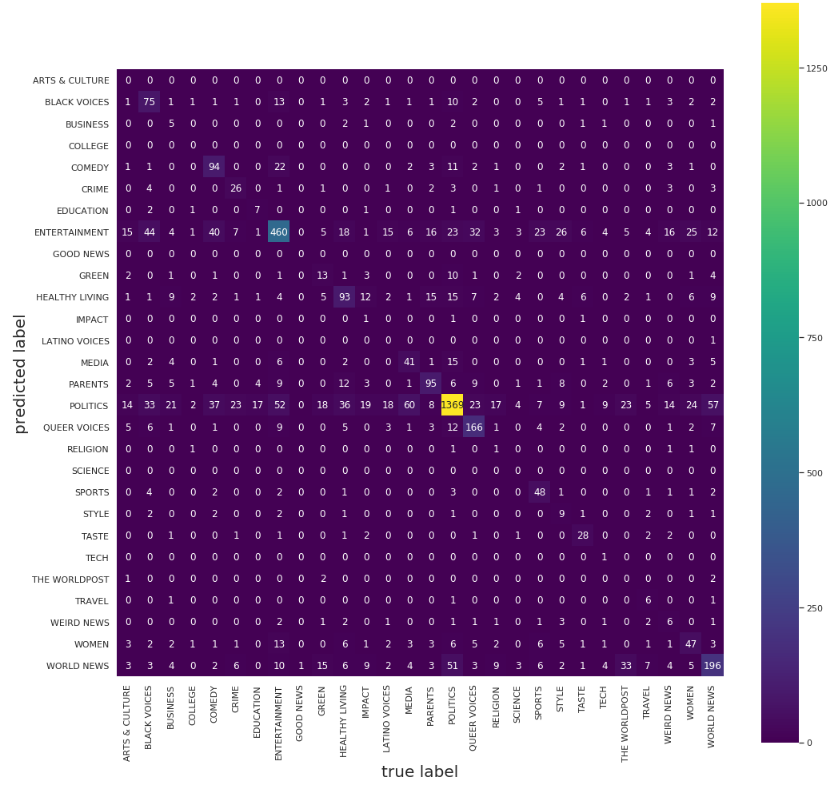

In [36]:
from IPython.display import Image
Image("/content/confusionmatrix2.png")

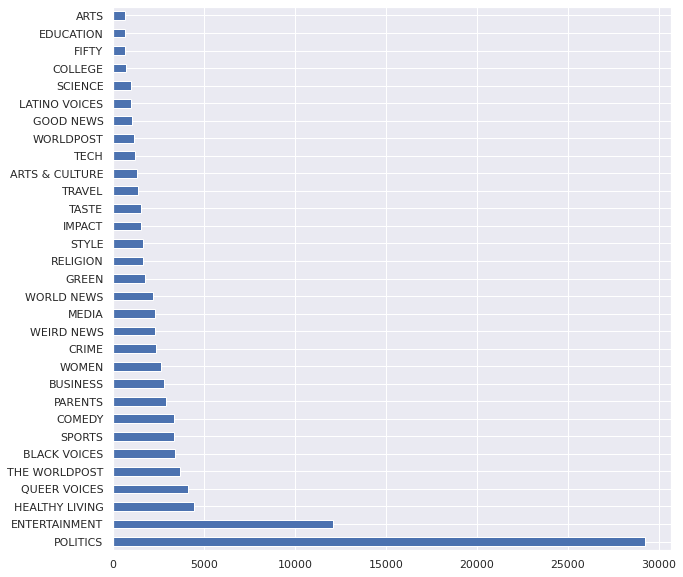

In [37]:
plt.figure(figsize=(10,10))
news_data_frame['category'].value_counts().plot(kind='barh')


The above figure shows the distribution of news articles in each category. It depicts that the “POLITICS” has very large data than the other categories. If the model has been created with this type of dataset, it takes most of the words into the “POLITICS” than predicting its real category. The model needs to created with balanced data, which is same number of data in all the categories.

So, there is a need of selection of appropriate data in each category before converting them into numeric identifiers after tokenizing. Here, the dataset has been sorted from maximum number of articels produced in each category and selected only the top 20 for this analysis. Each category had 1500 data i.e, articles, that brings the whole dataset to 30000 article in tolal. 


In [38]:
# for each, create the 'story' by adding together the headline and the short_description
news_data_frame["story"]  = [story['headline']+' - '+story['short_description'] for story in news_json]


news = pd.DataFrame(columns=news_data_frame.columns)
for category in categories:
    filtered_json = news_data_frame[news_data_frame["category"] == category].head(1500)
    news = pd.concat([news, pd.DataFrame(filtered_json)],ignore_index = True)

# look at first 10
news_data_frame = news
print("Number of stories: ",len(news_data_frame["story"]))

Number of stories:  30000


Before converting the stories into separate words, to maximise the accuracy of our prediction. The words like occurs often which doesnot add value to the analysis will be removed, example (is, the, a). This is because we want our classification model to identify the category using the distinct words rather than the words which is present in all the artilcles.

In [39]:
# do this for whole dataframe
news_data_frame['terms'] = [remove_stopwords(simple_preprocess(story,min_len=3)) for story in news_data_frame['story']]

In [40]:
word_counts = {}

for terms in news_data_frame["terms"]:
    for word in terms:
        if word in word_counts:
            word_counts[word] += 1
        else:
            word_counts[word] = 1
            
# sort the word_counts by counts
sorted_counts = {k: v for k, v in sorted(word_counts.items(), key=lambda item: item[1],reverse=True)}


In [41]:
news_data_frame["terms"].head(5)

0    [warriors, coach, steve, kerr, calls, nfl, ban...
1    [historic, victory, barbados, elects, female, ...
2    [police, killed, black, americans, moment, col...
3    [bet, chairman, ceo, debra, lee, stepping, lee...
4    [women, pulled, stops, land, dream, job, jessi...
Name: terms, dtype: object

The above words show the final words from the article which will be used in our model for creating and these words are saved into the “terms” column in our dataset. It also shows the number of times the words occurred in the whole dataset, for example, “trump” words occurs 3855 times in our dataset. 

### Convert Text into Tokens

In the next step, we will be using the tokenizer to convert the words into numeric identifiers using the this count. So, it can relate similar words into certain categories. The Tokenization process in text analytics converts each single word of the vocabulary of your corpus into a unique integer, which will the unique identifier that represents that word.

After tokenizing the dataset, there are 33503 unique tokens i.e, unique words. 


In [42]:
MAX_SEQUENCE_LENGTH = 100
MAX_NB_WORDS = 35000

tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(news_data_frame["terms"])

word_index = tokenizer.word_index
print('\nFound %s unique tokens.\n' % len(word_index))

sequences = tokenizer.texts_to_sequences( terms for terms in news_data_frame["terms"])


Found 33503 unique tokens.



In [43]:
# example of a sequence
print("sequence 0:")
print (sequences[0][:])
# length of sequence
print ("Total words in sequence 0: " + str(len(sequences[0][:])) + "\n")

print("sequence 1:")
print (sequences[1][:])
# length of sequence
print ("Total words in sequence 1: " + str(len(sequences[1][:])))

sequence 0:
[2521, 944, 797, 7196, 131, 312, 235, 614, 347, 6260, 20189, 525, 3307, 79, 862, 12643, 944, 4]
Total words in sequence 0: 18

sequence 1:
[845, 753, 15376, 6694, 265, 677, 458, 5892, 20190, 20191, 3784, 3308, 46, 15377, 79, 2228]
Total words in sequence 1: 16


### Convert Sequences of Tokens to Fixed Lengths

Each sequence of words has a different length. This represents a problem because Convolutional Neural Nets require the size of the input to be fixed. This is quite challenging because textual data does not have a predefined structure. To address this problem, we need to fix the length for each sequence (in this case we will fix it to 1000) and do padding in the data: we start to fill the sequences with zero's and we add the content's of the sequence until the maximum fixed length is reached.

In [44]:
# add zeros to the begining of the sequence until the maximum length is reached
data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)

# let's take a look at the first padded sequence:
print (data.shape)
print (data[0][:])
len(data)

(30000, 100)
[    0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0  2521   944
   797  7196   131   312   235   614   347  6260 20189   525  3307    79
   862 12643   944     4]


30000

The classes which is the categories needs to be matched with the order of padded data. So, we are encoding the categories as per the sequence in the dataset by 0s and 1s. 

In [45]:
labels = news_data_frame["category"].tolist()


In [46]:
# convert labels
enc = OneHotEncoder()
Y = enc.fit_transform(np.array(labels)[:, np.newaxis]).toarray()
Y.shape[1]

20

### Split Data into Training, Test and Validation Sets

Now that we took a look at our data and that we separated the data into a variable with the prediction, y, and another variable with the features, data, we need to split our data into two sets: a training set (used to estimate our model), and a test set (used to evaluate how good our model is).


In [47]:
# Split the data set into training, testing and validation sets
X_train, X_test, Y_train, Y_test = train_test_split(data, Y, test_size=0.3,random_state = 500)
X_validation, X_test, Y_validation, Y_test = train_test_split(X_test, Y_test, test_size=0.5, random_state=2)

In [48]:
print("training set dimensions:")
print(X_train.shape)

print("\nlabels training set dimensions:")
print(Y_train.shape)

print("\ntest set dimensions:")
print(X_test.shape)

print("\nlabels test set dimensions:")
print(Y_test.shape)

training set dimensions:
(21000, 100)

labels training set dimensions:
(21000, 20)

test set dimensions:
(4500, 100)

labels test set dimensions:
(4500, 20)



# Analysis With Our Naive Bayes Classifier



To capture relationships in words in the news articles, that are very difficult to capture, the embedding layer is used. An embedding is a mapping of a discrete categorical variable to a vector of continuous numbers. In the context of neural networks, embeddings are low-dimensional, learned continuous vector representations of discrete variables. Neural network embeddings are useful because they can reduce the dimensionality of categorical variables and meaningfully represent categories in the transformed space.

In other words, this layer can help us find the most similar words in our classification task. The Dropout layer has been added to the network to reduce the over fitting of training and test accuracy and the flatten layer is used to converting the multidimensional layers to one dimensional to the output. There 20 neurons as per the number of categories and the sigmoid is the activation function used because it exists between (0,1). Therefore, it is especially used in our model where we have to predict the probability as an output. Since the probability of anything exists only between the range of 0 and 1, sigmoid is the right choice. Due to this the out of the predicted category can have certain level on confidence which is probability of predicting the news category will be 0 to 1. Using all these the model has been created and fitted without training and validation dataset.

In [ ]:
# defining a very simple model
model = Sequential()

input_dim = len(word_index) + 1
model.add(Embedding(input_dim,100, input_length=MAX_SEQUENCE_LENGTH))
model.add(Dropout(0.3))
model.add(Flatten())
model.add(Dense(Y.shape[1], activation='sigmoid'))

# compile the model
model.compile(optimizer='nadam', loss='binary_crossentropy', metrics=['accuracy'])

# summarize the model
print(model.summary())


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 100)          3350300   
_________________________________________________________________
dropout (Dropout)            (None, 100, 100)          0         
_________________________________________________________________
flatten (Flatten)            (None, 10000)             0         
_________________________________________________________________
dense (Dense)                (None, 20)                200020    
Total params: 3,550,320
Trainable params: 3,550,320
Non-trainable params: 0
_________________________________________________________________
None


/opt/conda/lib/python3.7/site-packages/tensorflow_core/python/training/tracking/data_structures.py:720: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  if not isinstance(wrapped_dict, collections.Mapping):


In [ ]:
# define the callebacks to take into consideration during training
# stop training when convergence is achieved after 10 iterations
early_stop = EarlyStopping(monitor='val_loss', patience=15, verbose=1, mode='min')
# save the model after every epoch
callbacks_list = [early_stop]

# fit the model
history = model.fit(X_train, Y_train, epochs=5, validation_data=(X_validation, Y_validation), callbacks=callbacks_list, verbose=1)


Train on 21000 samples, validate on 4500 samples
Epoch 1/5
21000/21000 [==============================] - 21s 988us/sample - loss: 0.1900 - accuracy: 0.9494 - val_loss: 0.1651 - val_accuracy: 0.9507
Epoch 2/5
21000/21000 [==============================] - 17s 820us/sample - loss: 0.1315 - accuracy: 0.9556 - val_loss: 0.1280 - val_accuracy: 0.9567
Epoch 3/5
21000/21000 [==============================] - 17s 813us/sample - loss: 0.0892 - accuracy: 0.9670 - val_loss: 0.1183 - val_accuracy: 0.9598
Epoch 4/5
21000/21000 [==============================] - 16s 779us/sample - loss: 0.0614 - accuracy: 0.9778 - val_loss: 0.1188 - val_accuracy: 0.9608
Epoch 5/5
21000/21000 [==============================] - 16s 775us/sample - loss: 0.0420 - accuracy: 0.9864 - val_loss: 0.1214 - val_accuracy: 0.9608


# Evaluation Of Our Model's Performance

In [ ]:
# evaluate loaded model on test and training data
train_loss,train_acc= model.evaluate(X_train, Y_train, verbose=1)
test_loss,test_acc = model.evaluate(X_test, Y_test, verbose=1)
print('[Accuracy] Train: %.3f, Test: %.3f' % (train_acc, test_acc))
print('[Loss] Train: %.3f, Test: %.3f' % (train_loss, test_loss))

4500/4500 [==============================] - 0s 36us/sample - loss: 0.1193 - accuracy: 0.9609
[Accuracy] Train: 0.992, Test: 0.961
[Loss] Train: 0.028, Test: 0.119


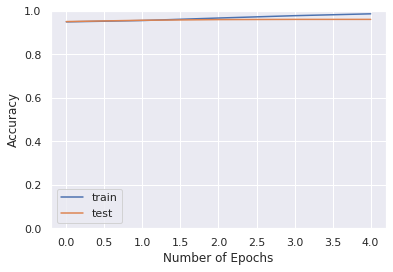

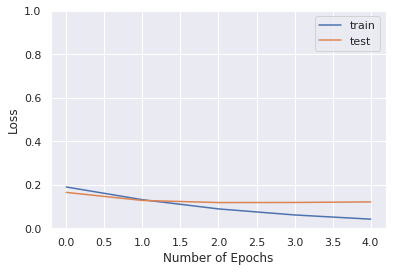

In [ ]:
# get model's training history
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.ylabel('Accuracy')
plt.xlabel('Number of Epochs')
plt.ylim([0, 1])
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.ylabel('Loss')
plt.xlabel('Number of Epochs')
plt.ylim([0, 1])
plt.legend()
plt.show()

The above graphs show an evaluation of the accuracy and loss of the created model. Following insights can be gained from the plotted graphs :

•	The model starts with high accuracy in the 1st epochs, which is because of the removal of stopwords from the news articles. This shows our model can identity distinct patterns from the start of the iteration i.e, distinct words in each news category.

•	The max accuracy achieved by our train and test dataset is around 99.2% and 96.1%. That is very high precision. There is a slightly over the training accuracy, but it is not a major issue.

•	From the accuracy graph, we can say that our model is neither over fitting nor under fitting.

•	From the loss graph, the training loss steadily decreases which showcase that our model using the dataset efficiently to classify.

•	The variance between the training and testing from the graph shows how much the data has been differentiated by over model over the end of the epochs. Larger the variance larger overlapping of words which can be hard to predict by our classifier. 


# AI Explainability Assessment With LIME

Here, we are going to analyze the BlackBox of our model using the Lime package. This can be done using our developed code below. This gives a detailed analysis like what makes our model conclude to the particular category. This can be done by breaking done, how our algorithm functions. It takes each word and relates to a certain category. If the words are mapped to many categories, it makes use of the weightage of other words. So, from this code, we can visualize, how much each word contributes to a certain category, additionally how much confidence our model showcases our prediction. It also shows the top 4 category from the maximum level of evidence of top 12 words it predicts. 

In [ ]:
# We'll initiate our explainer here, as we can parlay its functionality with the prediction process easier
explainer = LimeTextExplainer(class_names=categories)
class_colors = ['#d70000', '#008700', '#d7af00', '#005fff']


def draw_ev_chart(evidence, col, title_text):
    plt.figure(1, figsize=(10, len(evidence)/3.5))
    plt.barh(np.array(range(0,len(evidence)))+0.5,[t[1] for t in evidence], align='center',height=0.5, color=col)    # notice the 'height' argument
    plt.yticks(np.array(range(0,len(evidence)))+0.5, [t[0] for t in evidence], weight="normal", size="10")
    plt.xticks(weight='bold', size='8')
    plt.gca().axvline(0,color='k',lw=3)
    plt.title(title_text, weight="normal", size="10")
    plt.grid(False)
    plt.show()
    
def print_colorised(input_text, arg_categories, weightings, exp):
    print("\n\n\n")
    
    
    plt.figure(1, figsize=(4, len(weightings)/2))
    plt.barh(np.array(range(0,len(weightings)))+0.5, weightings, align='center',height=0.5, color=class_colors)    # notice the 'height' argument
    plt.yticks(np.array(range(0,len(weightings)))+0.5, categories, weight="normal", size="10")
    plt.xticks(weight='bold', size='8')
    plt.gca().axvline(0,color='k',lw=3)   # poor man's zero level
    plt.title("Class Weightings", weight="normal", size="10")
    plt.grid(False)
    plt.show()
    
    print("\n\n\n")
    
    ww = sorted(weightings, reverse = True)
    index_orders = []
    while(len(ww) > 2):
        index_to_drop = ww.index(max(ww))
        index_orders.append(index_to_drop)
        del ww[index_to_drop]
    index_orders.extend([1,0])
    
    word_class_list = []
    for l in range(0, len(arg_categories)):
        word_class_list.append([w[0] for w in exp.as_list(label=l)])
    reset_color_black = '\033[0m'
    constructed_replace_list = []
    for cl_v in range(0, len(word_class_list)):
        cl = index_orders[cl_v]
        for w in range(0, len(word_class_list[cl])):
            constructed_replace_list.append([len(word_class_list[cl][w]), word_class_list[cl][w], "\u001b[%sm" % (41+cl)])
    constructed_replace_list.sort(key=lambda x: x[0])
    output_text = input_text
    pattern_around = "(?<![a-zA-Z])"
    pattern_after = "(?![a-zA-Z])"
    for w in constructed_replace_list:
        output_text = re.compile(pattern_around+w[1]+pattern_after).sub( w[2]+w[1]+reset_color_black, output_text)
    print(output_text)
    
def c_fn(text):
    s = tokenizer.texts_to_sequences(text)
    d = pad_sequences(s, maxlen=MAX_SEQUENCE_LENGTH)
    return model.predict(d)

def run_explainability_test(input_sentence):
    # tokenize
    sequences = tokenizer.texts_to_sequences(input_sentence)
    # make padding
    data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
    exp = explainer.explain_instance(input_sentence, c_fn, num_features=12, num_samples=len(data), labels=list(range(20)))
    # get prediction
    weightings = [sum([x[1] for x in exp.as_list(label=y)]) for y in range(0,len(categories))]
    print( "\n\n\nPredicted values: " + categories[weightings.index(max(weightings))])
    sorted_weightings = sorted(weightings, reverse=False)
    sorted_categories = [categories for _,categories in sorted(zip(weightings,categories))]
    print_colorised(input_sentence, categories, weightings, exp)
    
    sorted_exp = sorted(range(len(weightings)), key=lambda i: weightings[i])[-4:]
    sorted_exp = list(reversed(sorted_exp) )
    for value, class_n in enumerate(sorted_exp):
        draw_ev_chart(exp.as_list(label=class_n),class_colors[value],"Evidence Of %s" % (categories[class_n]))
        
def predict(input_sentence):
    exp = model.predict(input_sentence)
    weightings = [sum([x[1] for x in exp.as_list(label=y)]) for y in range(0,len(categories))]
    result = categories[weightings.index(max(weightings))]
    return result



To form the confusion matrix, to identify how our model predicts by comparing true labels and its predicted labels, we are decoding the encoded test data labels for comparision in the same order as the prediction labels.  And also we are reshaping the test features to initiate the prediction and collected all the results in the order similar to the true test labels. 

In [ ]:
x_train = np.reshape(X_train, (len(X_train), 1, X_train.shape[1]))
x_test = np.reshape(X_test, (len(X_test), 1, X_test.shape[1]))

results = []
for index in range(0,len(x_test)):
    weightings = model.predict(x_test[index])
    r = categories[(weightings[0].tolist()).index(max(max(weightings)))]
    results.append(r)
    

/opt/conda/lib/python3.7/site-packages/tensorflow_core/python/keras/engine/training_v2_utils.py:544: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  if isinstance(inputs, collections.Sequence):


In [ ]:
def decode(datum):
    return np.argmax(datum)

Y_test_decoded = []
for i in range(0,len(Y_test)):
    datum = Y_test[i]
    decoded_datum = decode(Y_test[i])
    Y_test_decoded.append(categories[decoded_datum])    
    


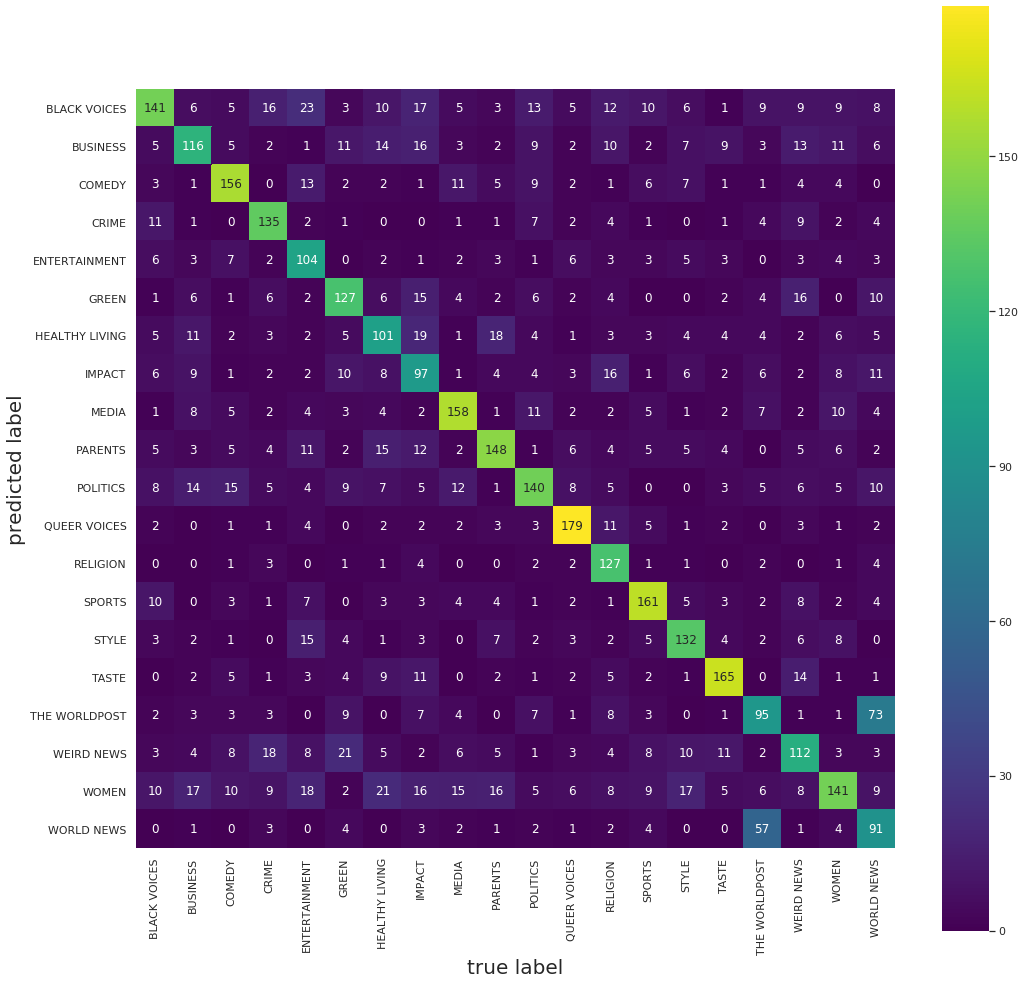

In [ ]:
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(Y_test_decoded, results)
plt.figure(figsize= (17,17))
#sns.heatmap(mat.T, square=True, fmt='d', cbar=True, xticklabels=categories, 
            #yticklabels=categories, annot=True)
sns.heatmap(mat.T, square=True, cbar=True, xticklabels=categories, 
            yticklabels=categories, annot=True, cmap=cm.viridis, fmt= 'g')
plt.xlabel('true label',fontsize= 20)
plt.ylabel('predicted label',fontsize= 20);


Insights from the confusion matrix are as follows:
    
•	The diagonal of different color depicts that there is more number of model prediction are accurate compared with the true labels.

•	Comparing this model matrix with the previous matrix we have tested, there is almost the same number of distribution of news articles in our dataset. Unlike the previous confusion matrix, this model has been tested with all categories of almost the same number of data

•	From this matrix, we can say that our model can predict all categories with some level of confidence rather than predicting with high confidence only on certain news categories.

•	 There are also some overlapping prediction of topics like “The world post” and “World news”. It is understandable that the articles from both of these topics we similar words around the world.


•	The category “Queer Voices” has a high number of correct predictions, it shows that the words present in the Queer Voices articles are more distinct than the other articles in the dataset.





Now, lets analyse the type of content of how the classifier works with the given dataset. So the given sentence is about SPORTS and we are trying to predict the news category using our created model. Using our created visualization code we can able to see which category contain how much confidence with respect to the given data. And also, we have developed for getting insights from the words related to which category. A word can be related to many categories but the level of confidence varies between the categories and from our analysis we can see what are words contributing for high level of confidence in the predicted category. Then we can analyse that the prediction of distinct word can contribute to some relation to the classified category. 






Predicted values: SPORTS






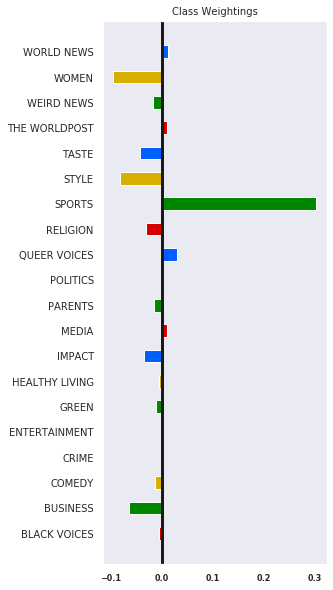





Maria Sharapova Stunned By Victoria Azarenka In Australian Open Final Afterward, Azarenka, more effusive with the press than normal, credited her coach of two years, Sam Sumyk, for his patient


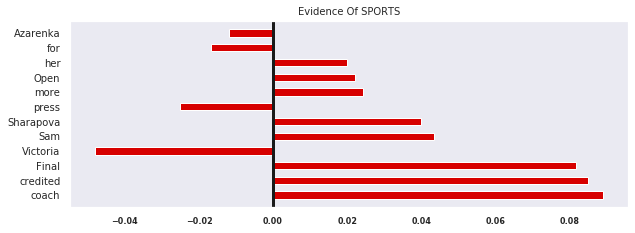

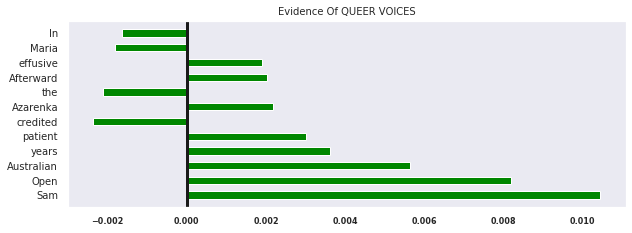

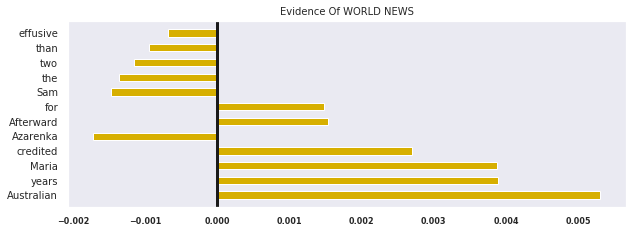

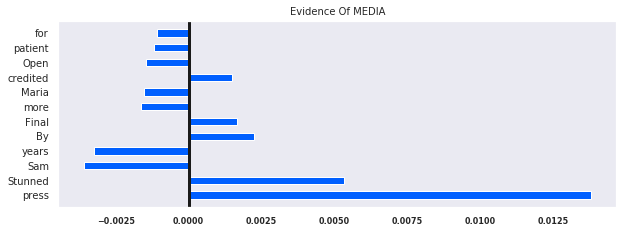

In [ ]:
# A sentence about sports
input_sentence = """Maria Sharapova Stunned By Victoria Azarenka In Australian Open Final Afterward, Azarenka, more effusive with the press than normal, credited her coach of two years, Sam Sumyk, for his patient"""
run_explainability_test(input_sentence)

Our model predicted the given article in the correct category i.e, sports. The classifier shows a clear cut of evidence about sports compared to other categories. The level of confidence is also high in the article. The confidence level is the sum of all the word's probability of being the certain category. So, here the sum of all the words contributed to the sports category leads to the predicted category. The words like “final”, “credited”, “coach” has a higher probability of occurring in the sports category which is reasonable.




Predicted values: THE WORLDPOST






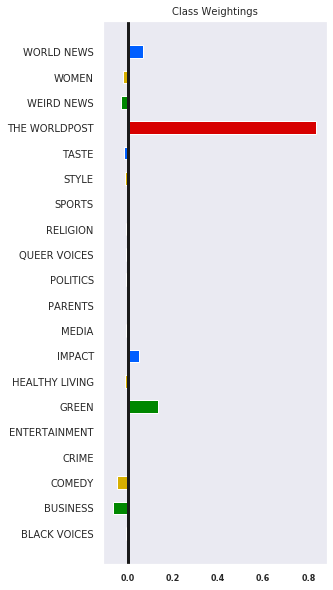





Australia is poised to join the world's most exclusive political organisation after US President Donald Trump called for an expansion of the Group of 7 nations without China in an attempt to build greater cooperation over restoring the global economy following the coronavirus pandemic.


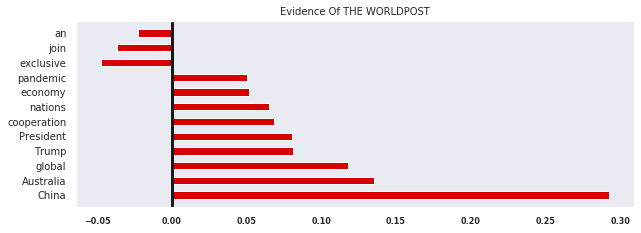

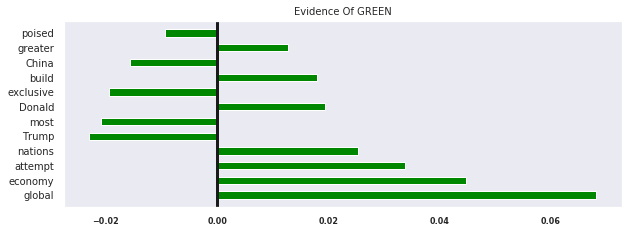

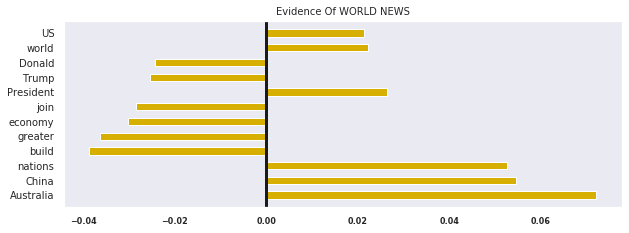

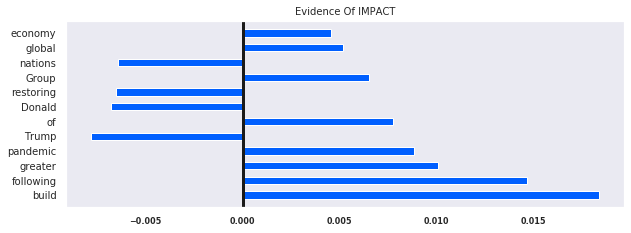

In [ ]:
# 2nd sentence about WorldPost
input_sentence = """Australia is poised to join the world's most exclusive political organisation after US President Donald Trump called for an expansion of the Group of 7 nations without China in an attempt to build greater cooperation over restoring the global economy following the coronavirus pandemic."""
run_explainability_test(input_sentence)

The sentance was about world post and the model predicts the category world post with good classification of words like country names “china”, “australia”, “global”, “nations” etc. Also it has very high amount of evidence with the number of words associated to the given article. 




Predicted values: BLACK VOICES






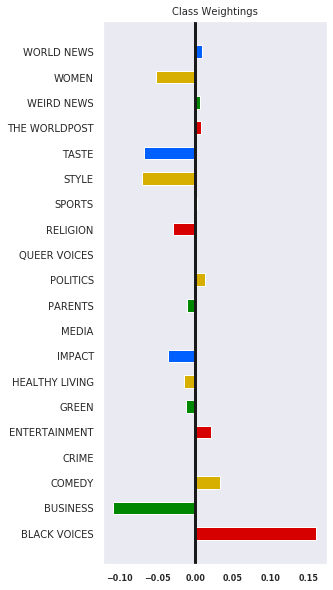





protests flare in the US for another night, tear gas fired at crowd outside the White House, live updates


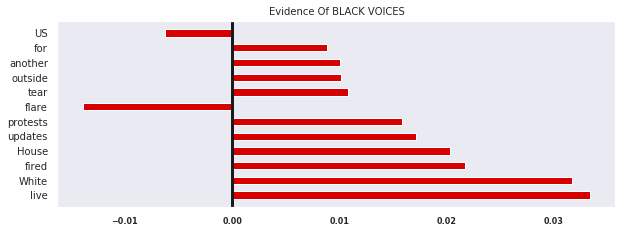

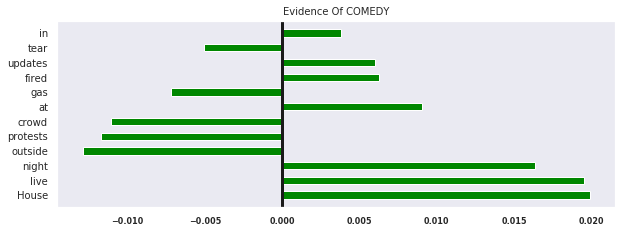

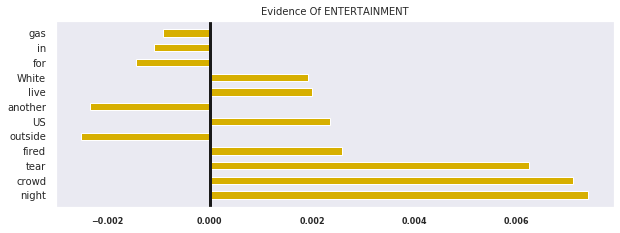

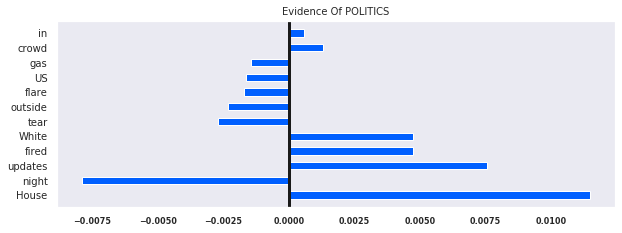

In [ ]:
# 3nd sentence about Crime
input_sentence = """protests flare in the US for another night, tear gas fired at crowd outside the White House, live updates"""
run_explainability_test(input_sentence)


From the above example, it was recent news about the protest happening in the US. The true category of the article is “Crime”, but our predicted category was “Black voices”. The following are the insights gained from our the above input in the analysis of this model:

•	No words are logically meant to be in the category “Black Voices”.

•	The level of confidence is not that high, but it has nothing to do with the predicted category. Anyhow, in the real implecation, the model gives an output as Black voices, which is wrong. 

•	The words which are most contributed are “fired”, “live”, “White”, “protests” and “tear”. These words are not linked to the “Black voices” but our model shows these are related to this category with some level of evidence. 

•	These words are logically linked to the crime category. But our model classifies incorrectly.

•	Let's also consider the number of words. This input article is just a headline without a detailed description compared to our previous category. 






Predicted values: CRIME






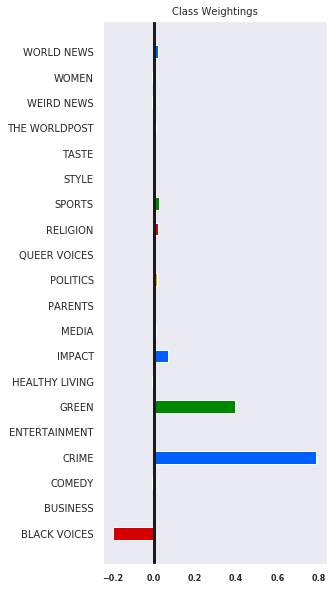





protests flare in the US for another night, tear gas fired at crowd outside the White House, live updates!The death this week of an unarmed black man at the hands of a Minnesota police officer has unleashed a wave of protests across the United States.
Demonstrators first turned out in the city of Minneapolis where George Floyd died, but rallies quickly broke out in Georgia, California, New York, Kentucky, Florida and Pennsylvania.


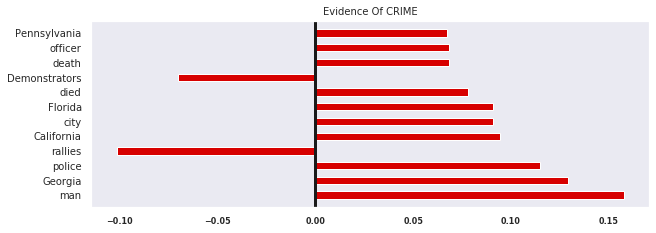

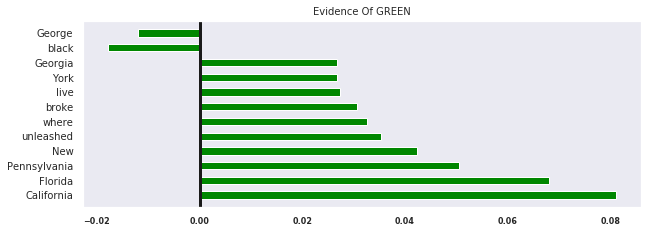

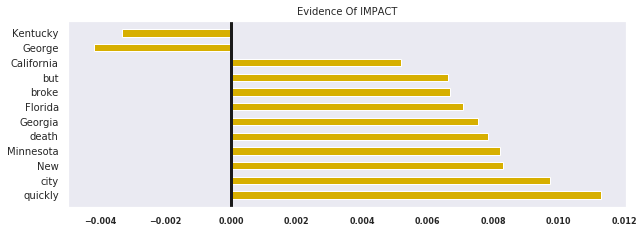

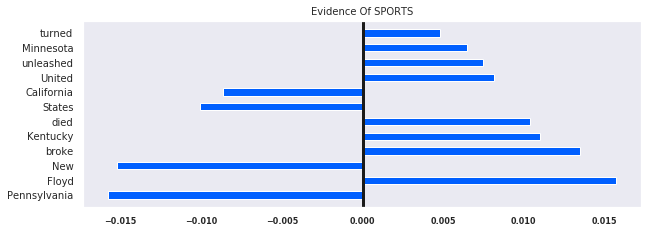

In [ ]:
# 4th - same as above sentence with detailed description
input_sentence = """protests flare in the US for another night, tear gas fired at crowd outside the White House, live updates!The death this week of an unarmed black man at the hands of a Minnesota police officer has unleashed a wave of protests across the United States.
Demonstrators first turned out in the city of Minneapolis where George Floyd died, but rallies quickly broke out in Georgia, California, New York, Kentucky, Florida and Pennsylvania."""
run_explainability_test(input_sentence)


This was the same article with detailed description. But the number of words in higher than the previous input. Following are the insights collected from the analysis:

•	It shows a significant confidence level that the given article is about crime. 

•	The context of the words mapped to the crime are logically correct and it is reasonable, unlike our previous insight.

•	The words connected to crime are “police”, “man”, “died”, “death”, “officer” etc. These words show high level of probability of being in the crime category.

•	Other categories also shows more number of logically related words to its categories. 

•	The data provided is more compared to our last input. This might have something to do the correct confidence level. 

#### But why?
Let's analyse further what makes the model to predict the above story in the wrong classification. We can analyze using the number of words contributed in the Black Voice category. 

In [ ]:
BlackVoicesTerms = news_data_frame[news_data_frame['category'] == "BLACK VOICES"]["terms"]

Black_voices_word_counts = {}

for terms in BlackVoicesTerms:
    for word in terms:
        if word in Black_voices_word_counts:
            Black_voices_word_counts[word] += 1
        else:
            Black_voices_word_counts[word] = 1
            
# sort the word_counts by counts
Black_voices_sorted_counts = {k: v for k, v in sorted(Black_voices_word_counts.items(), key=lambda item: item[1],reverse=True)[:20]}

Black_voices_sorted_counts

{'black': 610,
 'white': 152,
 'said': 149,
 'trump': 148,
 'people': 141,
 'women': 111,
 'new': 109,
 'police': 107,
 'year': 97,
 'history': 78,
 'man': 77,
 'says': 76,
 'racist': 68,
 'america': 66,
 'time': 61,
 'school': 58,
 'video': 58,
 'racism': 56,
 'panther': 55,
 'like': 55}

Text(0.5, 0, 'Counts')

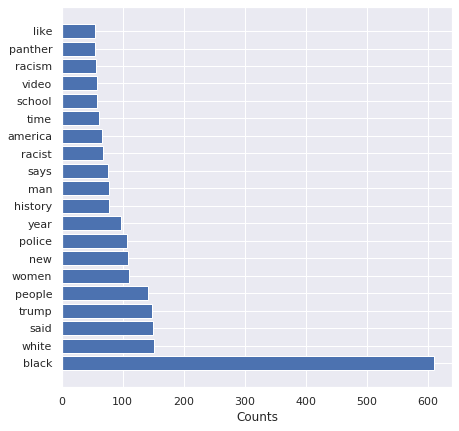

In [ ]:
plt.figure(figsize=(7,7))
plt.barh(list(Black_voices_sorted_counts.keys()), list(Black_voices_sorted_counts.values()))
plt.xlabel(xlabel="Counts")


From the above graph, it shows the words which occurs most in the Black voice category while creating the model. These words are from our dataset provided at the starting of the development of the model. Words like “white”, “Police” should not be a part of this category logically, which makes the dataset one-sided. We can see that our dataset provided which has more contexts like protesting, police, white, fired etc., Our model couldn’t find enough evidence of other categories because of fewer data. That’s made our model predict it in the wrong category but with less confidence.

### Combining all the insights and mapping it to business concern:

•	The model showed very high accuracy and loss using the training and test datasets for evaluation. This shows the model can classify and identify distinct words from the articles for each category.

•	Looking at the variance of the loss between training and testing dataset. They are very low, which depicts that the words used for training and testing data are not overlapping. The model distinguishes the words precisely and relates to certain categories. 

•	From the confusion matrix, we can come to the result that the model can classify all categories instead of working better on certain categories.

•	From the explainability, most the time, 3 of 4 analysis, the model predicts categories and classify at a higher rate of evidnce. These words are also making logical connections to the topic of prediction. 

•	But when the number of data given to the model is lower, i.e, inputing with less number of words. The model was not functioning quite well compared to a large number of data. It classifies words into wrong categories and the words are not logically making any connection to the topic of prediction. Also, the level of confidence is very low for the whole category.


# Potential Issues

If this model has been deployed in the news agencies, news syndicates website, mobile application, etc., it would classify the news article most of the time to its true labels. But, if the provided data is insufficient the model will predict given text in the wrong category. Example, what we have seen in our analysis before like the text is nothing to do with the Black Voice category but it matches words like “fired”, “tear”, “white” and “protests”. The level of confidence may very low but, at this point, it classifies into the wrong category.  This can be avoided if we implement certain conditions like the prediction should showcase certain evidence before deciding on the category. This may affect the perspective of the readers about the news and also the important stakeholders involved in the article. Also, the agencies can loss important values like customers, credits etc. 

# Conclusion

To conclude, the news agencies can use this model for classifying the news category. But, they should be taking into account the amount of data they provide from the article to our model. More data reduces the risks of predicting it in the wrong category. From the explainability of our model, to avoid these risk of minimal data in the future, news agencies can use the more filtered dataset with words logically and meaningfully connecting to the category. Also, as mention above, we can improve the algorithm by using more condition on finalizing the category with a certain level of confidence.  The interesting note to make is that, from our analysis, we can also see that news articles are categorized in a bit biased way like protests, arrests, crime words in the article to Black Voices. These words are more to do with the Crime category rather than Black Voices. These should be taken into account by the news agencies in the future. 